# Project: Using Reddit's API for Predicting Comments
### Author: Kihoon Sohn

### Table of Contents

- Notebook 1 - Data Fetching: `json` webscrap and unpack to dataframe
- **Notebook 2 - Data Cleansing(current)** : exploratory data analysis and feature engineering
- Notebook 3 - Data Modeling: build a predictive model

**Disclaimer**: Due to the file size restriction in GitHub, `/dataset/` folder and other large files were ignored by `.gitignore`. Therefore the notebook might not reproducible. 

In [1]:
# import libraries for the notebook

import pandas as pd
import numpy as np
np.random.seed(538)

import seaborn as sns
import matplotlib.pyplot as plt

import time
import datetime

### 2a: read datasets and merge

##### To have a larger dataset, I fetched data regularly in a week.
Dataset Summary
- fetched `reddit.com/hot.json` and dropped most of variables,
- but `title`, `subreddit`, `num of comments`, `fetched time`, `created utc`
- fetched **51,697 unduplicated posts from 5-25-2018 to 6-01-2018**

In [2]:
# let's concat previous fetched data

df1 = pd.read_csv('./dataset/1st_5K.csv')
df2 = pd.read_csv('./dataset/2nd_5K.csv')
df3 = pd.read_csv('./dataset/3rd_5K.csv')
df4 = pd.read_csv('./dataset/4th_5K.csv')
df5 = pd.read_csv('./dataset/5th_5K.csv')
df6 = pd.read_csv('./dataset/6th_5K.csv')

# I learned how to embed time in the filename.
df7 = pd.read_csv('./dataset/hotposts_crafted_ 30-05-2018 (1321hrs).csv')
df8 = pd.read_csv('./dataset/hotposts_crafted_ 30-05-2018 (1422hrs).csv')
df9 = pd.read_csv('./dataset/hotposts_crafted_ 30-05-2018 (1847hrs).csv')
df10 = pd.read_csv('./dataset/hotposts_crafted_ 30-05-2018 (1931hrs).csv')
df11 = pd.read_csv('./dataset/hotposts_crafted_ 30-05-2018 (2259hrs).csv')
df12 = pd.read_csv('./dataset/hotposts_crafted_ 31-05-2018 (0038hrs).csv')
df13 = pd.read_csv('./dataset/hotposts_crafted_ 31-05-2018 (0647hrs).csv')
df14 = pd.read_csv('./dataset/hotposts_crafted_ 31-05-2018 (1224hrs).csv')
df15 = pd.read_csv('./dataset/hotposts_crafted_ 31-05-2018 (2052hrs).csv')
df16 = pd.read_csv('./dataset/hotposts_crafted_ 01-06-2018 (0851hrs).csv')

# concat CSVs 
df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10,
                df11, df12, df13, df14, df15, df16], ignore_index=True)
print(df.shape)

# Check how many unique values in the merged dataset.
print(df['id'].nunique())

(105345, 7)
51697


### 2b: Clean up dataframe - set time and timedelta, drop cols

In [3]:
# drop duplicates and unnecessary column
# set `keep='last'` to keep the last duplicate.
df = df.drop_duplicates(subset='id', keep='last')
df.drop(columns='Unnamed: 0', axis=1, inplace=True)
print(df.shape)

(51697, 6)


In [4]:
# change data type into readable "datatime" format. 
# datetime64[s] shows date/time data by seconds. 

df['fetched time'] = df['fetched time'].astype('datetime64[s]')
df['created_utc'] = df['created_utc'].astype('datetime64[s]')

In [5]:
# create new column "age" by subtracting fetched time - created time.
# To make it readable, timedelta64 is needed. [m] gives by minutes-long, [h] by hours. 

df['age'] = df['fetched time'] - df['created_utc']
df['age'] = df['age'].astype('timedelta64[m]')
df.head()

,id,title,subreddit,num_comments,created_utc,fetched time,age
225,8m1wov,"It happens in anime, it happens in life",combinedgifs,407,2018-05-25 13:52:24,2018-05-25 20:10:12,377.0
226,8m19ri,Harvey Weinstein arrested on rape charges,television,1497,2018-05-25 12:14:43,2018-05-25 20:10:12,475.0
227,8m1mba,Spiderman and Tony,marvelstudios,245,2018-05-25 13:10:06,2018-05-25 20:10:12,420.0
228,8m1cnu,"2008 Youtube, was an amazing time to be alive",videos,524,2018-05-25 12:28:02,2018-05-25 20:10:12,462.0
230,8m173l,TIL Shakespeare coined or popularized many of ...,todayilearned,536,2018-05-25 12:02:23,2018-05-25 20:10:12,487.0


In [6]:
df.age.describe()

count    51697.000000
mean       627.707372
std        360.907441
min          7.000000
25%        335.000000
50%        573.000000
75%        882.000000
max       1625.000000
Name: age, dtype: float64

In [7]:
df.columns

Index(['id', 'title', 'subreddit', 'num_comments', 'created_utc',
       'fetched time', 'age'],
      dtype='object')

### 2c: Explore the data 
##### - Let's check which subreddit has the most number of posts


In [8]:
count_id = df.groupby('subreddit').agg({'id': 'count'})
top_sub = count_id.sort_values('id', ascending = False).head()
top_sub

,id
subreddit,
aww,1079
funny,867
PewdiepieSubmissions,588
memes,558
FortNiteBR,546


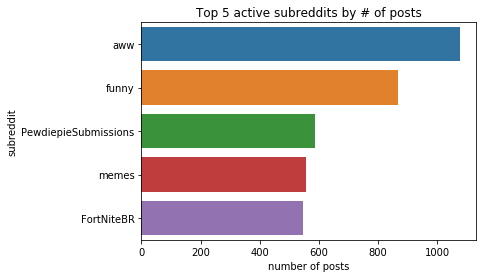

In [9]:
# plot the top 5 buzzing subreddit by # of posts

sns.barplot(x=top_sub['id'], y=top_sub.index) # challenge: annotate values in the plot
plt.xlabel("number of posts")
plt.title("Top 5 active subreddits by # of posts");

In [10]:
df['num_comments'].describe()

count    51697.000000
mean        69.125597
std        341.592320
min          0.000000
25%          6.000000
50%         16.000000
75%         43.000000
max      28236.000000
Name: num_comments, dtype: float64

In [11]:
# the median number and .75 percentile of the number of comments
median = np.percentile(df['num_comments'], 50)
per_75 = np.percentile(df['num_comments'], 75)
print("The median of the num of comments: ", median)
print("The 75th percentile of the num of comments: ", per_75)

The median of the num of comments:  16.0
The 75th percentile of the num of comments:  43.0


/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


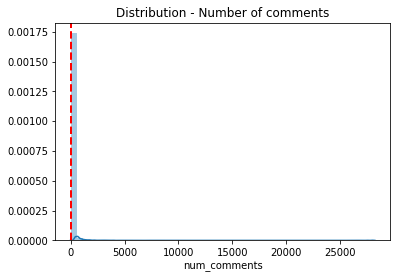

In [25]:
# plot number of comments distribution

sns.distplot(df['num_comments'])
plt.title("Distribution - Number of comments");

##### - Let's check which subreddits are most popular in the number of comments.

In [15]:
# Let's pull top 5 subreddit in the most number of comments
sub_mean = df.groupby('subreddit').agg({'num_comments': 'mean'})
top_com = sub_mean.sort_values('num_comments', ascending = False).head()
top_com

,num_comments
subreddit,
AskReddit,1939.209756
IAmA,1321.461538
AbuseInterrupted,816.000000
personalfinance,814.600000
gadgets,671.888889


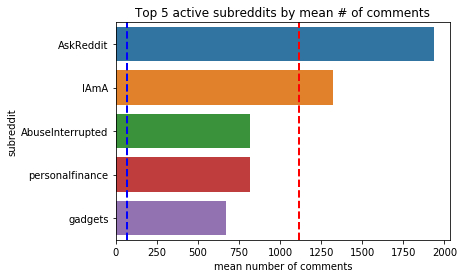

In [16]:
# plot the 5 subreddit

sns.barplot(x=top_com['num_comments'], y=top_com.index) # challenge: annotate values in the plot
plt.xlabel("mean number of comments")
plt.axvline(df['num_comments'].mean(), color='b', linestyle='dashed', linewidth=2)
plt.axvline(top_com['num_comments'].mean(), color='r', linestyle='dashed', linewidth=2)
plt.title("Top 5 active subreddits by mean # of comments");

/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


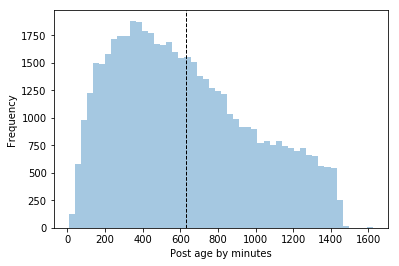

In [17]:
sns.distplot(df['age'], kde= False)
plt.axvline(df['age'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.xlabel("Post age by minutes")
plt.ylabel("Frequency");

##### - Check baseline accuracy

In [13]:
# make binary classification for High / Low number of comments
# Since # of comments are highly skewed as shown the plot above
# let's set the separator as 75th percentile.

# High gets 1, Low gets 0
df['comments'] = [1 if x >= per_75 else 0 for x in df['num_comments']]
df['comments'].value_counts()

0    38580
1    13117
Name: comments, dtype: int64

In [14]:
# Let's check the baseline accuracy for the model. 
df['comments'].value_counts()/len(df['comments'])

0    0.746272
1    0.253728
Name: comments, dtype: float64

### 2d: save it to csv

In [23]:
current_time = time.strftime("%m-%d-%Y")
df.to_csv('master_'+current_time+'(hotposts).csv')